# Importando bibliotecas

In [1]:
import logging
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import time
from datetime import datetime
from torch import nn  # Import the neural network module from PyTorch
import gym
from gym import spaces
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN, PPO
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.utils import resample
from tensorflow.keras.models import load_model

import sys
from stable_baselines3 import A2C

import os
sys.path.append(os.path.join('..'))
from classes._exploration import exploration
from classes._Env3WGym import Env3WGym
from classes._LoadInstances import LoadInstances
from classes._Agent import Agent
from classes._Supervised import Supervised
from classes._ValidationModel import ValidationModel
from classes._exploration import exploration

# Validação dos dados simulados

In [2]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' or 'PPO', 'RNA', 'A2C'
    type_instance='simulated'

    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:

            directory = f'..\\..\\logs\\{event_name}-{type_instance}'
            path_dataset = '..\\..\\..\\dataset'   
            path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            if not os.path.exists(path_model):
                os.makedirs(path_model)                
            
                    
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
            # Configuração do Logging
            logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')

            instances = LoadInstances(path_dataset)
            
            logging.info(f'Iniciando carregamento do dataset')
            dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
            logging.info(f'Fim carregamento do dataset')
            
            logging.info(f'Iniciando divisão do dataset em treino e teste')
                
            # Definindo a porcentagem para divisão entre treino e teste
            train_percentage = 0.8  # 80% para treino

            dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

            if model_type == 'DQN':
                logging.info(f'Iniciando treinamento do algoritmo DQN')    
                start_time = time.time()
                agente = Agent(path_model)
                model_agent, replaydir = agente.env3W_dqn(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo DQN')


                logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
                accuracy = agente.env3W_dqn_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
                logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')
                
            elif model_type == 'PPO':      
                logging.info(f'Iniciando treinamento do algoritmo PPO') 
                start_time = time.time()
                agente = Agent(path_model)
                model_agent = agente.env3W_ppo(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo PPO')

                logging.info(f'Iniciando avaliação do algoritmo PPO conjunto de teste')
                accuracy = agente.env3W_ppo_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando PPO')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando PPO')
                logging.info(f'Fim avaliação  do algoritmo PPO conjunto de teste')

            elif model_type == 'A2C':      
                logging.info(f'Iniciando treinamento do algoritmo A2C') 
                start_time = time.time()
                agente = Agent(path_model)
                model_agent = agente.env3W_a2c(dataset_train_scaled, n_envs = 5)  
                print(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do algoritmo A2C')

                logging.info(f'Iniciando avaliação do algoritmo A2C conjunto de teste')
                accuracy = agente.env3W_a2c_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando A2C')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando A2C')
                logging.info(f'Fim avaliação  do algoritmo A2C conjunto de teste')
            
            elif model_type == 'RNA':
                logging.info(f'Iniciando treinamento do modelo RNA') 
                supervised = Supervised(path_model, dataset_train_scaled, dataset_test_scaled)
                start_time = time.time()
                model_agent = supervised.keras_train()  
                print(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                logging.info(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                logging.info(f'Fim treinamento do modelo RNA')

                logging.info(f'Iniciando avaliação do modelo RNA conjunto de teste')
                accuracy = supervised.keras_evaluate(model_agent)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando RNA')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando RNA')
                logging.info(f'Fim avaliação  do modelo RNA conjunto de teste')

            #logging.info(f'Iniciando a validação do modelo {model_type}') 
            #validation = ValidationModel(model_type, event_name)

            #validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event_name}')
   

Número de amostras da classe 0: 684000
Número de amostras da classe 1: 2872713
Número de amostras da classe 101: 4766400


c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Abrupt Increase of BSW-simulated\tensorboard_logs'
Using cpu device
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN_0
Tempo de Treinamento DQN: 281.85s


c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Acurácia de 73.89% no conjunto de dados de teste usando DQN


# Validação com dados reais

In [3]:
if __name__ == '__main__':

    events_names = {
        # 0: 'Normal',
        1: 'Abrupt Increase of BSW',
        # 2: 'Spurious Closure of DHSV',
        # 3: 'Severe Slugging',
        # 4: 'Flow Instability',
        # 5: 'Rapid Productivity Loss',
        # 6: 'Quick Restriction in PCK',
        # 7: 'Scaling in PCK',
        # 8: 'Hydrate in Production Line'
    }

    event_name = [value for key, value in events_names.items() if key != 0][0]
    
    models = ['DQN'] # 'DQN' or 'PPO', 'RNA', 'A2C'
    type_instance='real'

    for model_type in models:
        for event_name in [value for key, value in events_names.items() if key != 0]:

            directory = f'..\\..\\logs\\{event_name}-{type_instance}'
            path_dataset = '..\\..\\..\\dataset'   
            path_model = f'..\\models\\{event_name}-{type_instance}\\{model_type}'  

            if not os.path.exists(directory):
                os.makedirs(directory)
            
            if not os.path.exists(path_model):
                os.makedirs(path_model)                
            
                    
            current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            log_filename = f'{directory}\\{current_time}_{event_name}-{type_instance}_{model_type}-log.txt'
            # Configuração do Logging
            logging.basicConfig(filename=log_filename, filemode='w', level=logging.INFO, format='[%(levelname)s]\t%(asctime)s - %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p', force=True, encoding='utf-8')

            instances = LoadInstances(path_dataset)
            
            logging.info(f'Iniciando carregamento do dataset')
            dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)    
            logging.info(f'Fim carregamento do dataset')
            
            logging.info(f'Iniciando divisão do dataset em treino e teste')
                
            # Definindo a porcentagem para divisão entre treino e teste
            train_percentage = 0.8  # 80% para treino

            dataset_train_scaled, dataset_test_scaled, dataset_validation_scaled = instances.data_preparation(dataset, train_percentage)

            if model_type == 'DQN':
                #logging.info(f'Iniciando treinamento do algoritmo DQN')    
                #start_time = time.time()
                agente = Agent(path_model)
                #model_agent = agente.env3W_dqn(dataset_train_scaled, n_envs = 5)  
                #print(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                #logging.info(f"Tempo de Treinamento DQN: {round(time.time() - start_time, 2)}s")
                #logging.info(f'Fim treinamento do algoritmo DQN')

                model_agent = DQN.load(f"{path_model.replace('real', 'simulated')}\_DQN_Env3W") 
                logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste')
                accuracy = agente.env3W_dqn_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN')
                logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste')
                
                #replay_buffer_path = os.path.join("..", "models", "Abrupt Increase of BSW-simulated", "DQN") # , "replay_buffer"
                logging.info(f'Iniciando treinamento do algoritmo DQN (Continual Learning)')
                model_agent_cl = agente.env3W_dqn_cl(model_agent, dataset_test_scaled, replaydir = replaydir, n_envs = 5)
                logging.info(f'Iniciando avaliação do algoritmo DQN conjunto de teste (Continual Learning)')
                accuracy = agente.env3W_dqn_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando DQN (Continual Learning)')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando DQN (Continual Learning)')
                logging.info(f'Fim avaliação  do algoritmo DQN conjunto de teste (Continual Learning)')
                
                
            elif model_type == 'PPO':      
            
                #start_time = time.time()
                agente = Agent(path_model)
                #model_agent = agente.env3W_ppo(dataset_train_scaled, n_envs = 5)  
                #print(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                #logging.info(f"Tempo de Treinamento PPO: {round(time.time() - start_time, 2)}s")
                #logging.info(f'Fim treinamento do algoritmo PPO')

                
                model_agent = PPO.load(f"{path_model.replace('real', 'simulated')}\_PPO_Env3W")
                logging.info(f'Iniciando avaliação do algoritmo PPO conjunto de teste')
                accuracy = agente.env3W_ppo_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando PPO')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando PPO')
                logging.info(f'Fim avaliação  do algoritmo PPO conjunto de teste')

            elif model_type == 'A2C':      
            
                #start_time = time.time()
                agente = Agent(path_model)
                #model_agent = agente.env3W_a2c(dataset_train_scaled, n_envs = 5)  
                #print(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                #logging.info(f"Tempo de Treinamento A2C: {round(time.time() - start_time, 2)}s")
                #logging.info(f'Fim treinamento do algoritmo A2C')

                model_agent = A2C.load(f"{path_model.replace('real', 'simulated')}/_A2C_Env3W")

                logging.info(f'Iniciando avaliação do algoritmo A2C conjunto de teste')
                accuracy = agente.env3W_a2c_eval(dataset_test_scaled, model_agent, n_envs = 1)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando A2C')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando A2C')
                logging.info(f'Fim avaliação  do algoritmo A2C conjunto de teste')
            
            elif model_type == 'RNA':
                #logging.info(f'Iniciando treinamento do modelo RNA')  
                
                supervised = Supervised(os.path.dirname(path_model.replace('real', 'simulated')), dataset_train_scaled, dataset_test_scaled)
                #start_time = time.time()
                #model_agent = supervised.keras_train()  
                #print(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                #logging.info(f"Tempo de Treinamento RNA: {round(time.time() - start_time, 2)}s")
                #logging.info(f'Fim treinamento do modelo RNA')
                
                model_agent = supervised.keras_load_model("RNA_Env3W") # Reinforcement-Learning\src\models\Abrupt Increase of BSW-simulated\RNA_Env3W
                
                logging.info(f'Iniciando avaliação do modelo RNA conjunto de teste')
                accuracy = supervised.keras_evaluate(model_agent)
                print(f'Acurácia de {accuracy * 100:.2f}% no conjunto de dados de teste usando RNA')
                logging.info(f'Acurácia de {accuracy:.5f} no conjunto de dados de teste usando RNA')
                logging.info(f'Fim avaliação  do modelo RNA conjunto de teste')

            #logging.info(f'Iniciando a validação do modelo {model_type}') 
            validation = ValidationModel(model_type, event_name)

            validation.validation_model(accuracy, dataset_validation_scaled, model_agent)

            logging.info(f'Concluído a execução do algoritmo {model_type}-{type_instance} para o evento {event_name}')
   

Número de amostras da classe 0.0: 195376
Número de amostras da classe 1.0: 10417
Número de amostras da classe 101.0: 95658


c:\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Acurácia de 28.92% no conjunto de dados de teste usando DQN
Para visualizar os logs do TensorBoard, execute:
tensorboard --logdir='..\models\Abrupt Increase of BSW-real\tensorboard_logs'
Logging to ..\models\Abrupt Increase of BSW-simulated\tensorboard_logs\DQN-CL_0
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.03e+03 |
|    ep_rew_mean      | -562     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2538     |
|    time_elapsed     | 11       |
|    total_timesteps  | 930145   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0278   |
|    n_updates        | 46007    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 6.03e+03 |
|    ep_rew_mean      | -191     |
|    exploration_rate | 0.01     |
| time/               |          

# Exploração dos dados

In [4]:
events_names = {
    # 0: 'Normal',
    1: 'Abrupt Increase of BSW',
    # 2: 'Spurious Closure of DHSV',
    # 3: 'Severe Slugging',
    # 4: 'Flow Instability',
    # 5: 'Rapid Productivity Loss',
    # 6: 'Quick Restriction in PCK',
    # 7: 'Scaling in PCK',
    # 8: 'Hydrate in Production Line'
}

event_name = [value for key, value in events_names.items() if key != 0][0]


type_instance='simulated'

instances = LoadInstances(path_dataset)
            

dataset, _ = instances.load_instance_with_numpy(events_names, type_instance=type_instance)

c:\Users\kaike\Documents\UFSC\3W\Reinforcement-Learning\src\notebook\..\classes\_exploration.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=var, data=filtered_data, ax=axes[i], palette=class_palette, showfliers=False)
c:\Users\kaike\Documents\UFSC\3W\Reinforcement-Learning\src\notebook\..\classes\_exploration.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=var, data=filtered_data, ax=axes[i], palette=class_palette, showfliers=False)
c:\Users\kaike\Documents\UFSC\3W\Reinforcement-Learning\src\notebook\..\classes\_exploration.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` v

KeyboardInterrupt: 

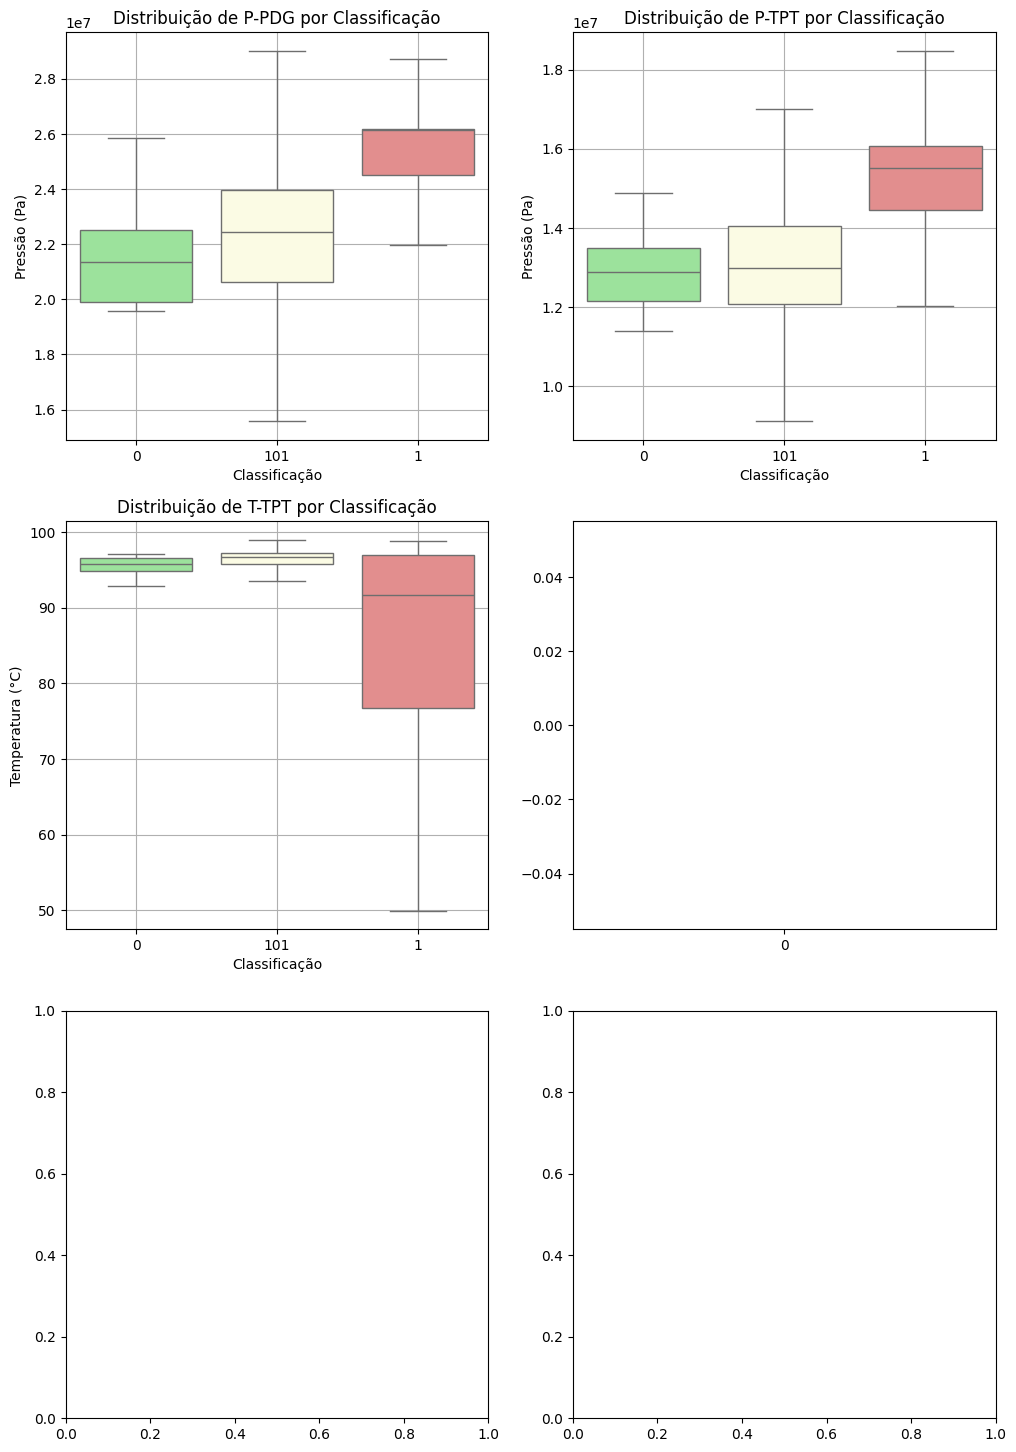

In [5]:


explora = exploration(pd.DataFrame(dataset, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']))

explora.quartiles_plot(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP'], f'Quartis das variáveis {type_instance} do evento {event_name}')